# Street Matching
1. Read a GPS trace
2. Download a street network of that zone/city
3. resample both the linestring describing the street network and the GPS trace at constant distance (evry 1 meters)
4. Use sax to transform each resampled linestring in a sequence of symbols 
5. Build the Aho–Corasick "Finite State Machine" with the resampled linestring
6. Search all the linestring contained in the trajectory
7. Reconstruct the most probable path (#matched compatible symbols/totla trajectory length)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange
import osmnx as ox
from CaGeo.algorithms import BasicFeatures as bf
from pyts.approximation import SymbolicAggregateApproximation
import ahocorasick
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import geopandas as geopd

def df_to_basic_feat(df:pd.DataFrame, fun):
    return fun(df.x.values, df.y.values)

In [2]:
traces = pd.read_csv("tracks_1/track_points.csv")

print(f"# Traces: {len(traces.track_fid.unique())}\t{traces.track_fid.unique()}")

# Traces: 17	[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [3]:
graph = ox.graph_from_address("Salviano, Livorno, Italy", network_type='drive')
#graph = ox.graph_from_place("Livorno, Italy", network_type='drive')
archi = ox.graph_to_gdfs(graph, nodes=False)
archi.explore()

In [4]:
def rolling_avg(data, window=3):
    kernel = np.ones(window) / window
    return np.convolve(data, kernel, mode='same')

def resample_df(df_to_resample=pd.DataFrame, distance_in_meters=1, iterazioni=2):
    dist = bf.distance(df_to_resample.x, df_to_resample.y, accurate=True).sum()*1000

    resampling_perc = np.linspace(0, 1, max(2, round(dist/distance_in_meters)))
    
    ls = LineString(df_to_resample)
    
    resampled_traceV2 = []

    for point in ls.interpolate(resampling_perc, normalized=True):
        x, y = point.coords.xy
        resampled_traceV2.append((x[0], y[0]))
        
    if iterazioni == 1:
        return pd.DataFrame(resampled_traceV2, columns=["x", "y"])
    else:
        return resample_df(pd.DataFrame(resampled_traceV2, columns=["x", "y"]), distance_in_meters, iterazioni-1)

def resample_df_old(df_to_resample=pd.DataFrame, distance_in_meters=1):
    resampled_trace = df_to_resample.copy(deep=True)
    resampled_trace["distance"] = (bf.distance(resampled_trace.x.values, resampled_trace.y.values, accurate=True)*1000).cumsum()
    new_index = list(range(0, round(resampled_trace.distance.max())+1, distance_in_meters))
    new_index_df = pd.DataFrame(new_index, columns=["distance"])
    new_index_df["keep"] = True
    new_index_df.distance = new_index_df.distance.astype(float)
    resampled_trace = pd.merge(new_index_df, resampled_trace, on=['distance'], how='outer').sort_values("distance")
    resampled_trace[["x", "y"]] = resampled_trace[["x", "y"]].interpolate("linear")
    resampled_trace.keep = resampled_trace.keep.fillna(False)
    
    return resampled_trace[resampled_trace.keep]#.drop(columns=["distance", "keep"])

# Hyper

In [26]:
meters = 10
resampling_it = 1
skip = 2 #meters*skip
smoothing=1
symbols = 8

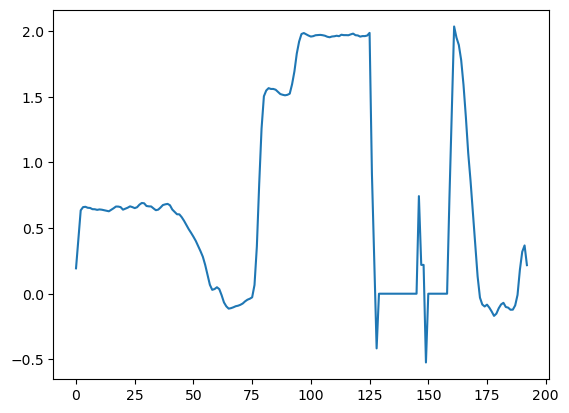

None

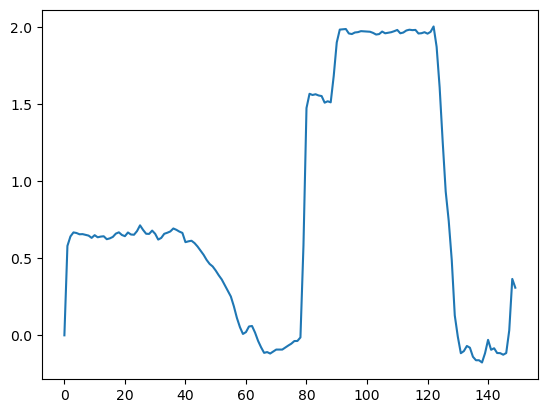

In [27]:
resampled_trace = []

for el in traces[traces.track_fid == 2].to_dict("records"):
    resampled_trace.append((el["time"], el["X"], el["Y"]))
    
resampled_trace = pd.DataFrame(resampled_trace, columns=["time", "x", "y"])[["x", "y"]]

plt.plot(rolling_avg(df_to_basic_feat(resampled_trace, bf.direction)))
display(plt.show())

resampled_trace = resample_df(resampled_trace, meters, resampling_it)

display(plt.plot(df_to_basic_feat(resampled_trace, bf.direction)))

In [28]:
df_tmp = pd.DataFrame(archi.iloc[1].geometry.coords, columns=["x", "y"])
tmp = resample_df(df_tmp, meters, resampling_it)

geopd.GeoDataFrame(tmp, geometry=geopd.points_from_xy(tmp.x, tmp.y), crs="EPSG:4326").explore()

In [29]:
resampled_archi = [] #u, v, key, osmid

for i in tqdm(range(len(archi))):
    df_tmp = pd.DataFrame(archi.iloc[i].geometry.coords, columns=["x", "y"])
    tmp = resample_df(df_tmp, meters, resampling_it)
    if len(tmp) > skip*2+2:
        tmp = resample_df(df_tmp, meters, resampling_it).iloc[skip:-skip:]
    archi.iloc[i, archi.columns.tolist().index("geometry")] = LineString(tmp)

  0%|          | 0/691 [00:00<?, ?it/s]

In [30]:
#plt.plot(df_to_basic_feat(resampled_trace, bf.direction)[1:])

In [31]:
class my_sax:
    def __init__(self, n_bins, strategy):
        self.n_bins = n_bins
        self.thr = np.linspace(-np.pi, np.pi, n_bins+1)
        
    def fit(self):
        return self
    def transform(self, X):
        lista = []
        for el in X[0]:
            for minimo, massimo, lettera in zip(self.thr[:-1], self.thr[1:], iter("abcdefghilmnopqrstuvz")):
                if minimo < el and massimo >= el:
                    lista.append(lettera)
                    break
                    
        return np.array(lista).reshape((1, -1))

In [34]:

#sax = SymbolicAggregateApproximation(n_bins=5, strategy="quantile").fit(df_to_basic_feat(resampled_trace, bf.direction)[1:]) #n_bins tra 2 e 26 compresi

sax = my_sax(n_bins=symbols, strategy="quantile")

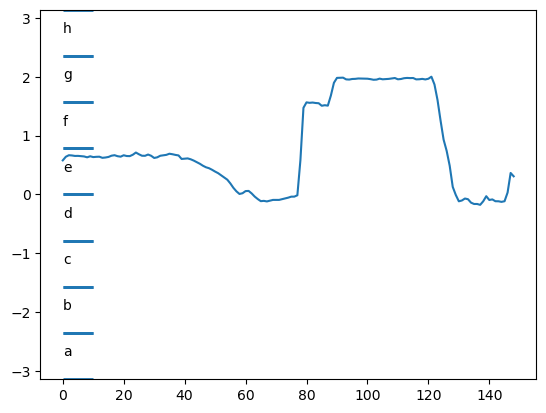

In [35]:
fig, ax = plt.subplots()

ax.set_ylim(-np.pi, np.pi)

for minimo, massimo, lettera in zip(sax.thr[:-1], sax.thr[1:], iter("abcdefghilmnopqrstuvz")):
    ax.hlines(y=minimo, xmin=0, xmax=10, linewidth=2)
    ax.hlines(y=massimo, xmin=0, xmax=10, linewidth=2)
    ax.text(0, (minimo+massimo)/2, lettera, fontsize=10)

plt.plot(df_to_basic_feat(resampled_trace, bf.direction)[1:])

In [36]:
trace_word = "".join(map(str, sax.transform(df_to_basic_feat(resampled_trace, bf.direction)[1:].reshape(1, -1))[0]))

In [37]:
trace_word

'eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeedddddddddddddddefffffffffggggggggggggggggggggggggggggggggggggffeeedddddddddddddddddeee'

In [38]:
len(df_to_basic_feat(resampled_trace, bf.direction)[1:])

149

In [39]:
automaton = ahocorasick.Automaton()

for idx, el in enumerate(tqdm(archi.reset_index().to_dict("records"))):
    try:
        direction = rolling_avg(df_to_basic_feat(pd.DataFrame(el["geometry"].coords, columns=["x", "y"]), bf.direction)[1:])
        #plt.plot(direction)
        word = "".join(map(str, sax.transform(direction.reshape(1, -1))[0]))
        automaton.add_word(word, (idx, (el["u"], el["v"], el["key"]), el["name"]))
        #print(word)
        
        if not el["oneway"]:
            direction = df_to_basic_feat(pd.DataFrame(list(el["geometry"].coords)[::-1], columns=["x", "y"]), bf.direction)[1:]
            word = "".join(map(str, sax.transform(direction.reshape(1, -1))[0]))
            automaton.add_word(word, (idx, (el["u"], el["v"], el["key"]), "rev_"+str(el["name"])))
    except:
        pass
    
    

  0%|          | 0/691 [00:00<?, ?it/s]

In [40]:
automaton.make_automaton()

In [41]:
for a in automaton.iter("aaaa"):
    print(a)

(0, (506, (1697770861, 1697770862, 0), 'rev_Via di Colline'))
(1, (574, (2066911138, 881717616, 0), 'rev_Via Sicilia'))
(1, (506, (1697770861, 1697770862, 0), 'rev_Via di Colline'))
(2, (684, (8957761926, 332455701, 0), 'rev_Via Giulio Anzilotti'))
(2, (574, (2066911138, 881717616, 0), 'rev_Via Sicilia'))
(2, (506, (1697770861, 1697770862, 0), 'rev_Via di Colline'))
(3, (679, (8703850441, 2308657634, 0), 'rev_Via degli Etruschi'))
(3, (684, (8957761926, 332455701, 0), 'rev_Via Giulio Anzilotti'))
(3, (574, (2066911138, 881717616, 0), 'rev_Via Sicilia'))
(3, (506, (1697770861, 1697770862, 0), 'rev_Via di Colline'))


In [42]:
res = []

for _, a in automaton.iter(trace_word):
    res.append(a)
    
res = pd.DataFrame(res, columns=["idx", "idx_osm", "name"])
res.name = res.name.astype(str)
res.drop_duplicates().head()

,idx,idx_osm,name
0,578,"(2103420189, 891112270, 0)",rev_Via Marche
1,674,"(8703850439, 1630195578, 0)",rev_Via degli Etruschi
3,688,"(8957761938, 8957761929, 0)",nan
6,679,"(8703850441, 2308657634, 0)",Via degli Etruschi
10,573,"(2066911134, 2066911138, 0)",Via Sicilia


In [43]:
archi[archi.index.isin(res.idx_osm.unique())].explore()

In [44]:
import folium

map_center = [resampled_trace['y'].mean(), resampled_trace['x'].mean()]
my_map = folium.Map(location=map_center, zoom_start=16)

resampled_trace["word"] = [i for i in trace_word] + ["nan"]

for index, row in tqdm(resampled_trace.iloc[25:40].iterrows()):
    folium.Marker(
        location=[row['y'], row['x']],
        popup=row["word"]
    ).add_to(my_map)
    
my_map

0it [00:00, ?it/s]

In [45]:
for el in automaton.iter(trace_word):
    print(el)

(0, (578, (2103420189, 891112270, 0), 'rev_Via Marche'))
(1, (674, (8703850439, 1630195578, 0), 'rev_Via degli Etruschi'))
(1, (578, (2103420189, 891112270, 0), 'rev_Via Marche'))
(2, (688, (8957761938, 8957761929, 0), nan))
(2, (674, (8703850439, 1630195578, 0), 'rev_Via degli Etruschi'))
(2, (578, (2103420189, 891112270, 0), 'rev_Via Marche'))
(3, (679, (8703850441, 2308657634, 0), 'Via degli Etruschi'))
(3, (688, (8957761938, 8957761929, 0), nan))
(3, (674, (8703850439, 1630195578, 0), 'rev_Via degli Etruschi'))
(3, (578, (2103420189, 891112270, 0), 'rev_Via Marche'))
(4, (573, (2066911134, 2066911138, 0), 'Via Sicilia'))
(4, (679, (8703850441, 2308657634, 0), 'Via degli Etruschi'))
(4, (688, (8957761938, 8957761929, 0), nan))
(4, (674, (8703850439, 1630195578, 0), 'rev_Via degli Etruschi'))
(4, (578, (2103420189, 891112270, 0), 'rev_Via Marche'))
(5, (243, (385092726, 2126570915, 0), 'Via Niccolò Paganini'))
(5, (573, (2066911134, 2066911138, 0), 'Via Sicilia'))
(5, (679, (87038504

  0%|          | 0/8 [00:00<?, ?it/s]

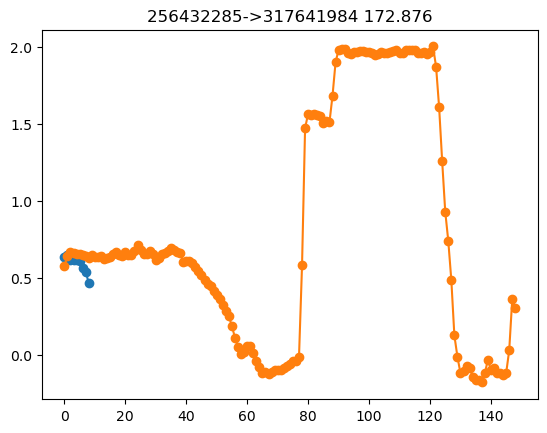

eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeedddddddddddddddefffffffffggggggggggggggggggggggggggggggggggggffeeedddddddddddddddddeee
256432285 eeeeeeeee


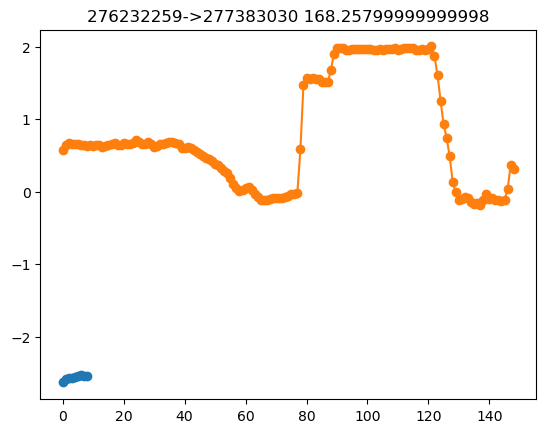

eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeedddddddddddddddefffffffffggggggggggggggggggggggggggggggggggggffeeedddddddddddddddddeee
276232259 aaaaaaaaa


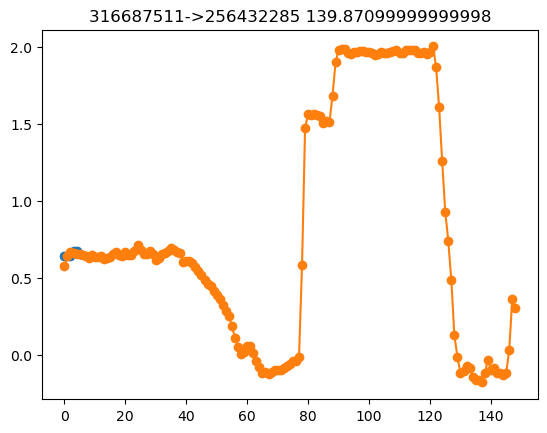

eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeedddddddddddddddefffffffffggggggggggggggggggggggggggggggggggggffeeedddddddddddddddddeee
316687511 eeeeee


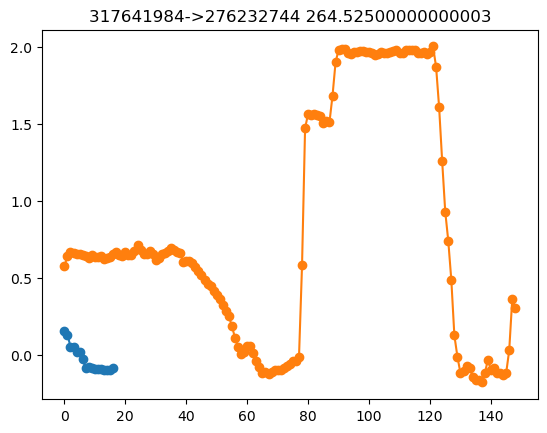

eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeedddddddddddddddefffffffffggggggggggggggggggggggggggggggggggggffeeedddddddddddddddddeee
317641984 eeeeeeddddddddddd


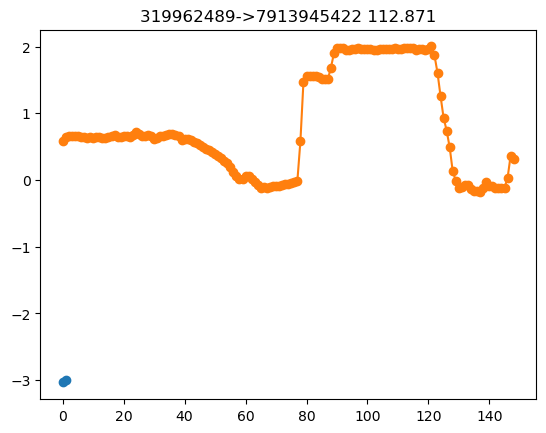

eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeedddddddddddddddefffffffffggggggggggggggggggggggggggggggggggggffeeedddddddddddddddddeee
319962489 aa


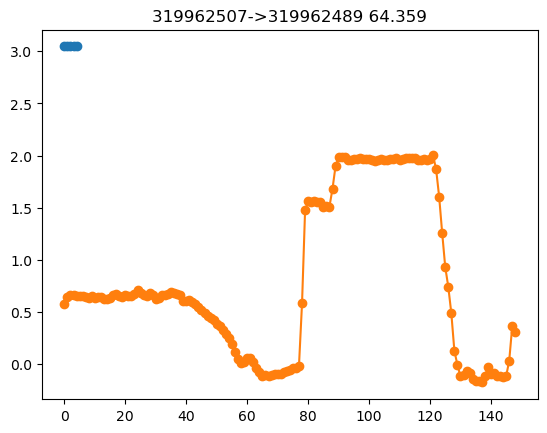

eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeedddddddddddddddefffffffffggggggggggggggggggggggggggggggggggggffeeedddddddddddddddddeee
319962507 hhhhh


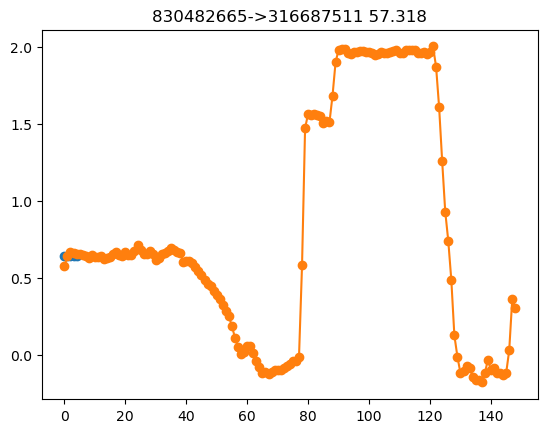

eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeedddddddddddddddefffffffffggggggggggggggggggggggggggggggggggggffeeedddddddddddddddddeee
830482665 eeeee


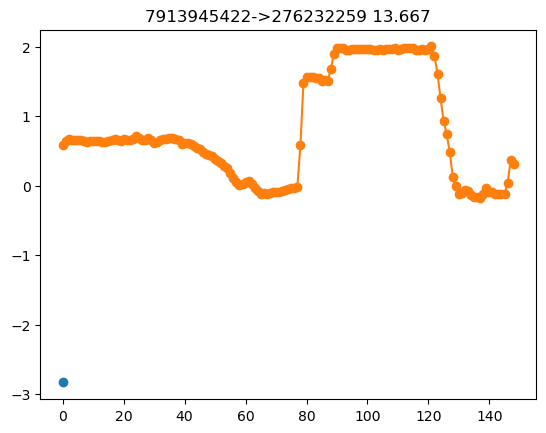

eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeedddddddddddddddefffffffffggggggggggggggggggggggggggggggggggggffeeedddddddddddddddddeee
7913945422 a


In [46]:
for idx, el in enumerate(tqdm(archi[archi.name == "Viale Francesco Petrarca"].reset_index().to_dict("records"))):
    direction = df_to_basic_feat(pd.DataFrame(el["geometry"].coords, columns=["x", "y"]), bf.direction)[1:]
    plt.plot(direction, marker='o')
    plt.plot(df_to_basic_feat(resampled_trace, bf.direction)[1:], marker='o')
    plt.title(f"{el['u']}->{el['v']} {el['length']}")
    plt.show()
    word = "".join(map(str, sax.transform(direction.reshape(1, -1))[0]))
    print(trace_word)
    print(el['u'], word)



    if not el["oneway"]:
        direction = df_to_basic_feat(pd.DataFrame(list(el["geometry"].coords)[::-1], columns=["x", "y"]), bf.direction)[1:]
        word = "".join(map(str, sax.transform(direction.reshape(1, -1))[0]))

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

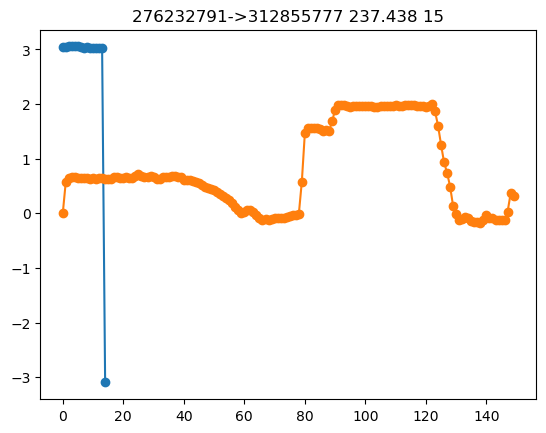

eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeedddddddddddddddefffffffffggggggggggggggggggggggggggggggggggggffeeedddddddddddddddddeee
276232791 hhhhhhhhhhhhhha
False


0it [00:00, ?it/s]

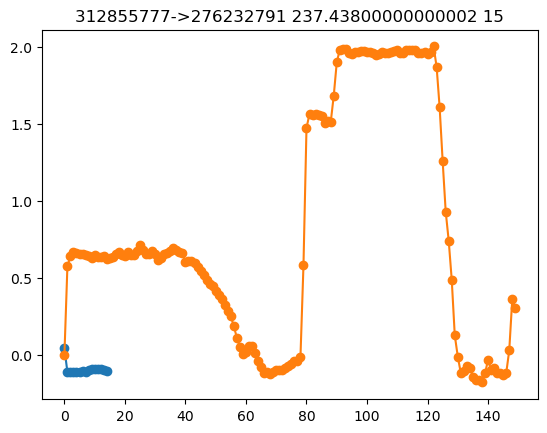

eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeedddddddddddddddefffffffffggggggggggggggggggggggggggggggggggggffeeedddddddddddddddddeee
312855777 edddddddddddddd
True


0it [00:00, ?it/s]

In [47]:
my_map = None

for idx, el in enumerate(tqdm(archi[archi.name == "Viale del Risorgimento"].reset_index().to_dict("records"))):
    resampled = pd.DataFrame(el["geometry"].coords[::-1], columns=["x", "y"])
    direction = df_to_basic_feat(resampled, bf.direction)[1:]

    resampled_trace["word"] = [i for i in trace_word] + ["nan"]
    word = "".join(map(str, sax.transform(direction.reshape(1, -1))[0]))
    
    if my_map is None:
        map_center = [resampled['y'].mean(), resampled['x'].mean()]
        my_map = folium.Map(location=map_center, zoom_start=16)

    for i, (index, row) in enumerate(tqdm(resampled.iterrows())):
        folium.Marker(
            location=[row['y'], row['x']], icon=folium.Icon(color='blue'),
            popup=f"{word[i%len(word)]} - {i}"
        ).add_to(my_map)

    plt.plot(direction, marker='o')
    plt.plot(df_to_basic_feat(resampled_trace, bf.direction), marker='o')
    
    plt.title(f"{el['u']}->{el['v']} {el['length']} {len(direction)}")
    plt.show()
    
    print(trace_word)
    print(el['u'], word)
    print(word in trace_word)



    #if not el["oneway"]:
    #    direction = df_to_basic_feat(pd.DataFrame(list(el["geometry"].coords)[::-1], columns=["x", "y"]), bf.direction)[1:]
    #    word = "".join(map(str, sax.transform(direction.reshape(1, -1))[0]))
    #display(my_map)
    #break
    
for i, (index, row) in enumerate(tqdm(resampled_trace.iterrows())):
        folium.Marker(
            location=[row['y'], row['x']], icon=folium.Icon(color='black'),
            popup=f"{trace_word[i%len(trace_word)]} - {i}"
        ).add_to(my_map)
        
my_map

In [48]:
df_to_basic_feat(resampled_trace, bf.distance).std()

0.0008201501618686947

In [49]:
rolling_avg(df_to_basic_feat(resample_df(resampled, smoothing, resampling_it), bf.distance), window=smoothing).std()

8.06148943745628e-05